# Challenge Set 5 (Classification)¶

Topic: Classification

Date: 02/03/2016

Name: Kenneth Myers

Worked with: NA

In [91]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

%matplotlib inline



## Challenge 1
Load the data into a pandas dataframe. Replace 'y's with 1s, 'n's with 0s.

Now, almost every representative has a ?. This represents the absence of a vote (they were absent or some other similar reason). If we dropped all the rows that had a ?, we would throw out most of our data. Instead, we will replace ? with the best guess in the Bayesian sense: in the absence of any other information, we will say that the probability of the representative saying YES is the ratio of others that said YES over the whole votes.

So, convert each ? to this probability (when yes=1 and no=0, this is the mean of the column)

In [92]:
def read_data(filename):
    with open(filename) as f:
        data = pd.read_csv(f)
        
    return data

In [93]:
congressional_data = read_data('house-votes-84.csv')

In [94]:
vote_cols = [str(i) for i in range(1,17)]

In [95]:
#vote_cols

In [96]:
congressional_data[congressional_data == 'y'] = 1
congressional_data[congressional_data == 'n'] = 0
for i in vote_cols:
    congressional_data[i][congressional_data[i] == '?'] = congressional_data[i].value_counts()[1]/\
                                                (congressional_data[i].value_counts()[1]+\
                                                 congressional_data[i].value_counts()[0])

In [97]:
#congressional_data

## Challenge 2

Split the data into a test and training set. Use this function:

    from sklearn.cross_validation import train_test_split

In [98]:
train, test = train_test_split(congressional_data, test_size=0.30, random_state=4444)

## Challenge 3

Using scikit.learn's KNN algorithm, train a model that predicts the party (republican/democrat):

    from sklearn.neighbors import KNeighborsClassifier

Try it with a lot of different k values (number of neighbors), from 1 to 20, and on the test set calculate the accuracy (number of correct predictions / number of all predictions) for each k

You can use this to calculate accuracy:

    from sklearn.metrics import accuracy_score

Which k value gives the highest accuracy?

In [99]:
def findMaxKNN(train, test):
    accuracy_scores = []
    k_values = range(1,21)
    
    for k in k_values:
        party_model = KNeighborsClassifier(n_neighbors=k)
        party_model.fit(train[vote_cols], train.Party)
        test_prediction = party_model.predict(test[vote_cols])
        acc_score = accuracy_score(test.Party, test_prediction)
        accuracy_scores.append(acc_score)
        
    max_k = np.argmax(accuracy_scores) + 1
        
    return (max_k, accuracy_scores[max_k])
    
    

In [100]:
findMaxKNN(train,test)

(6, 0.91603053435114501)

## Challenge 4

Make a similar model but with LogisticRegression instead, calculate test accuracy.

In [101]:
def logRegFit(X_train, y_train):
    logreg_model = LogisticRegression()
    logreg_model.fit(X_train, y_train)
    
    return logreg_model

In [102]:
def logRegAcc(train,test): 
    logreg_fit = logRegFit(train[vote_cols], train.Party)
    test_prediction = logreg_fit.predict(test[vote_cols])
    
    return accuracy_score(test.Party, test_prediction)

In [103]:
logreg_acc = logRegAcc(train,test)
print(logreg_acc)

0.93893129771


## Challenge 5

Make a bar graph of democrats and republicans. How many of each are there?

Make a very simple predictor that predicts 'democrat' for every incoming example.

Just make a function that takes in an X --an array or matrix with input examples--, and returns an array of the same length as X, where each value is 'democrat'. For example, if X is three rows, your function should return ['democrat','democrat','democrat']. Make a y_predicted vector using this and measure its accuracy.

Do the same with predicting 'republican' all the time and measure its accuracy.

[<matplotlib.text.Text at 0x10e6a8eb8>, <matplotlib.text.Text at 0x10e6c5f28>]

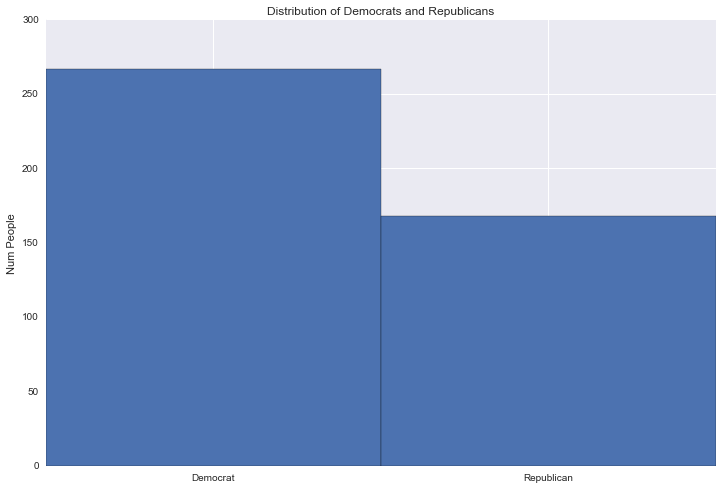

In [104]:
ind = np.array([1,2])
offset = .5

fig, ax = plt.subplots()
pols = ax.bar(ind, congressional_data.Party.value_counts(), width=1)
fig.set_size_inches(12, 8, forward=True)

ax.set_ylabel('Num People')
ax.set_title('Distribution of Democrats and Republicans')
ax.set_xticks(ind+offset)
ax.set_xticklabels(('Democrat', 'Republican'))

In [105]:
congressional_data.Party.value_counts()

democrat      267
republican    168
Name: Party, dtype: int64

In [106]:
def getDemocratsOnly(df):
    length = len(df)
    return np.array(['democrat' for _ in range(length)])

In [107]:
#getDemocratsOnly(range(10))

In [108]:
def getRepublicansOnly(df):
    length = len(df)
    return np.array(['republican' for _ in range(length)])

In [109]:
def consPredAcc(test, cons='democrat'):
    if cons.lower() == 'democrat':
        test_prediction = getDemocratsOnly(test)
    elif cons.lower() == 'republican':
        test_prediction = getRepublicansOnly(test)
    else:
        return print('Bad cons value')
    
    return accuracy_score(test.Party, test_prediction)

In [110]:
dem_cons_acc = consPredAcc(test)
dem_cons_acc

0.58778625954198471

In [111]:
rep_cons_acc = consPredAcc(test, cons='republican')
rep_cons_acc

0.41221374045801529

## Challenge 6

Plot the accuracies as a function of k. Since k only matters for KNN, your logistic regression accuracy, 'democrat' predictor accuracy and 'republican' predictor accuracy will stay the same over all k, so each of these three will be a horizontal line. But the KNN accuracy will change with k.

In [112]:
def loopKNN(train, test):
    accuracy_scores = []
    k_values = range(1,21)
    
    for k in k_values:
        party_model = KNeighborsClassifier(n_neighbors=k)
        party_model.fit(train[vote_cols], train.Party)
        test_prediction = party_model.predict(test[vote_cols])
        acc_score = accuracy_score(test.Party, test_prediction)
        accuracy_scores.append(acc_score)
        
    max_k = np.argmax(accuracy_scores) + 1
        
    return k_values, accuracy_scores

In [113]:
k_values, y_knn = loopKNN(train,test)
y_logreg = [logreg_acc for _ in k_values]
y_consdem = [dem_cons_acc for _ in k_values]
y_consrep = [rep_cons_acc for _ in k_values]

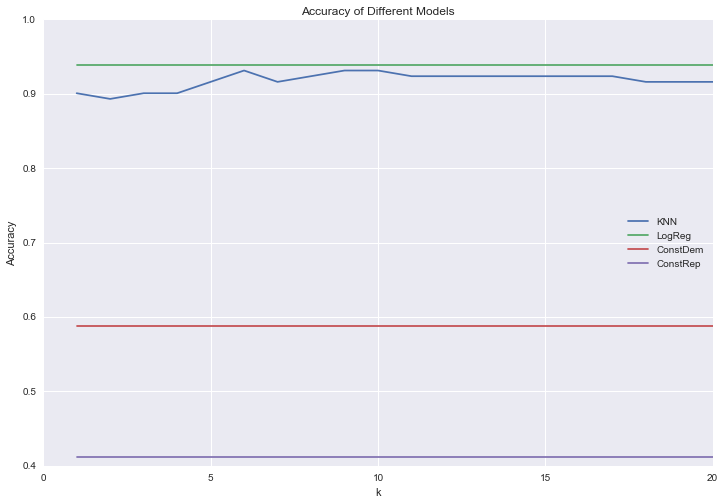

In [114]:
fig,ax = plt.subplots()

ax.plot(k_values, y_knn, label='KNN')
ax.plot(k_values, y_logreg, label='LogReg')
ax.plot(k_values, y_consdem, label='ConstDem')
ax.plot(k_values, y_consrep, label='ConstRep')

fig.set_size_inches(12, 8, forward=True)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.legend(loc='best')

## Challenge 7

Plot a learning curve for the logistic regression model. But instead of going through the painstaking steps of doing it yourself, use this function:

    from sklearn.learning_curve import learning_curve

This will give you the m, training errors and testing errors. All you need to do is plot them. You don't even need to give it separate training/test sets. It will do crossvalidation all by itself. Easy, isn't it? : ) Remember, since it does cross-validation, it doesn't have a single training error or test error per m value. Instead, it has one for each fold (separate partition) of the cross validation. A good idea is to take the mean of these errors from different folds. This gives you a meaningful single number per m. What I mean is that doing something like:

    train_cv_err = np.mean(train_err, axis=1)
    test_cv_err = np.mean(ts_err, axis=1)

Before plotting m vs train_cv_err and m vs test_cv_err, where train_err and test_err are the vectors returned by the learning curve function. The np.mean(...., axis=1) means take the mean along axis 1 (axis 1 is the columns axis-- for each row, you have a bunch of columns, each corresponding to a cross validation fold, you are averaging these columns for each row).

Draw the learning curve for KNN with the best k value as well.

### Learning Curve for LogReg

In [115]:
train_sizes = [ 0.1, 0.3, 0.5, 0.7, 0.9, 1]

In [116]:
train_sizes_abs, train_err, test_err = learning_curve(LogisticRegression(), congressional_data[vote_cols], congressional_data.Party, train_sizes=train_sizes, cv=5)

In [117]:
train_cv_err = np.mean(train_err, axis=1)
test_cv_err = np.mean(test_err, axis=1)

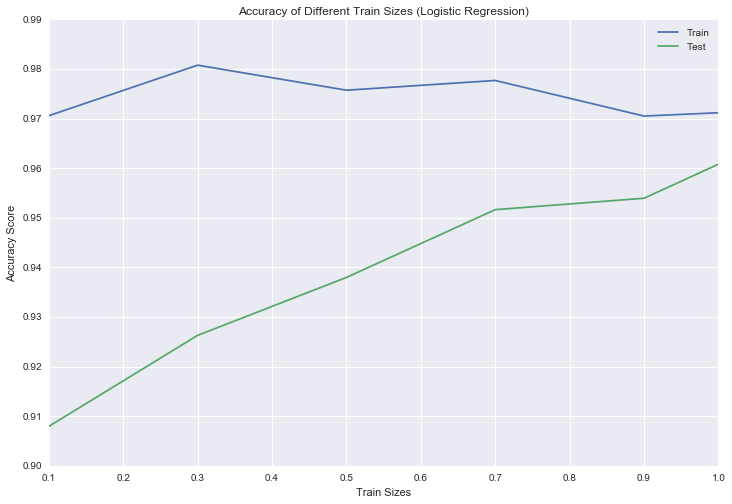

In [118]:
fig,ax = plt.subplots()

ax.plot(train_sizes, train_cv_err, label='Train')
ax.plot(train_sizes, test_cv_err, label='Test')

fig.set_size_inches(12, 8, forward=True)
plt.xlabel('Train Sizes')
plt.ylabel('Accuracy Score')
plt.title('Accuracy of Different Train Sizes (Logistic Regression)')
plt.legend(loc='best')

### Learning Curve for KNN, n=6

In [119]:
train_sizes_abs, train_err, test_err = learning_curve(KNeighborsClassifier(n_neighbors=6), congressional_data[vote_cols], congressional_data.Party, train_sizes=train_sizes, cv=5)

In [120]:
train_cv_err = np.mean(train_err, axis=1)
test_cv_err = np.mean(test_err, axis=1)

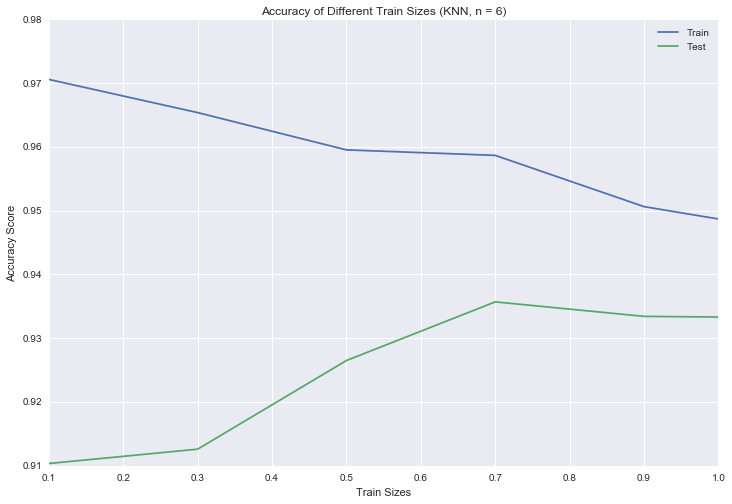

In [121]:
fig,ax = plt.subplots()

ax.plot(train_sizes, train_cv_err, label='Train')
ax.plot(train_sizes, test_cv_err, label='Test')

fig.set_size_inches(12, 8, forward=True)
plt.xlabel('Train Sizes')
plt.ylabel('Accuracy Score')
plt.title('Accuracy of Different Train Sizes (KNN, n = 6)')
plt.legend(loc='best')

## Challenge 8

This is a preview of many other classification algorithms that we will go over. Scikit.learn has the same interface for all of these, so you can use them exactly the same way as you did LogisticRegression and KNeighborsClassifier. Use each of these to classify your data and print the test accuracy of each:

Gaussian Naive Bayes

    from sklearn.naive_bayes import GaussianNB
    
SVM (Support Vector Machine) Classifier

    from sklearn.svm import SVC

Decision Tree

    from sklearn.tree import DecisionTreeClassifier

Random Forest

    from sklearn.ensemble import RandomForestClassifier

In [122]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [123]:
def getGaussNBScore(train,test):
    model = GaussianNB()
    fit = model.fit(train[vote_cols], train.Party)
    test_prediction = fit.predict(test[vote_cols])
    score = accuracy_score(test.Party, test_prediction)
    
    return score

getGaussNBScore(train,test)

0.93893129770992367

In [124]:
def getSVCScore(train,test):
    model = SVC()
    fit = model.fit(train[vote_cols], train.Party)
    test_prediction = fit.predict(test[vote_cols])
    score = accuracy_score(test.Party, test_prediction)
    
    return score

getSVCScore(train,test)

0.95419847328244278

In [125]:
def getDTCScore(train,test):
    model = DecisionTreeClassifier()
    fit = model.fit(train[vote_cols], train.Party)
    test_prediction = fit.predict(test[vote_cols])
    score = accuracy_score(test.Party, test_prediction)
    
    return score

getDTCScore(train,test)

0.95419847328244278

In [126]:
def getRFCScore(train,test, n_estimators=10):
    model = RandomForestClassifier(n_estimators=n_estimators)
    fit = model.fit(train[vote_cols], train.Party)
    test_prediction = fit.predict(test[vote_cols])
    score = accuracy_score(test.Party, test_prediction)
    
    return score

getRFCScore(train,test,10)

0.96946564885496178

## Challenge 9

There is actually a way to do cross validation quickly to get your accuracy results for an algorithm, without separating training and test yourself:

    from sklearn.cross_validation import cross_val_score

Just like the learning_curve function, this takes a classifier object, X and Y. Returns accuracy (or whatever score you prefer by using the scoring keyword argument). Of course, it will return a score for each cross validation fold, so to get the generalized accuracy, you need to take the mean of what it returns.

Use this function to calculate the cross validation score of each of the classifiers you tried before.

In [127]:
from sklearn.cross_validation import cross_val_score

#### GaussianNB

In [128]:
np.mean(cross_val_score(GaussianNB(), congressional_data[vote_cols], congressional_data.Party, cv=10))

0.93977398570421822

#### SVC

In [129]:
np.mean(cross_val_score(SVC(), congressional_data[vote_cols], congressional_data.Party, cv=10))

0.95828047921071191

#### DecisionTreeClassifier

In [130]:
np.mean(cross_val_score(DecisionTreeClassifier(), congressional_data[vote_cols], congressional_data.Party, cv=10))

0.93296083761200044

#### RandomForestClassifier

In [131]:
np.mean(cross_val_score(RandomForestClassifier(), congressional_data[vote_cols], congressional_data.Party, cv=10))

0.96742675928722444

## Challenge 10

Instead of 'democrat' or 'republican', can you predict the vote of a representative based on their other votes?

Reload the data from scratch. Convert y-->1, n-->0.

Choose one vote. Build a classifier (logistic regression or KNN), that uses the other votes (do not use the party as a feature) to predict if the vote will be 1 or 0.

Convert each ? to the mode of the column (if a senator has not voted, make their vote 1 if most others voted 1, make it 0 if most others voted 0).

Calculate the cross validation accuracy of your classifier for predicting how each representative will vote on the issue.

In [132]:
congressional_data_a = read_data('house-votes-84.csv')
congressional_data_a[congressional_data_a == 'y'] = 1
congressional_data_a[congressional_data_a == 'n'] = 0

In [133]:
congressional_data_b = deepcopy(congressional_data_a)
congressional_data_b.head()

,Party,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,republican,0,1,0,1,1,1,0,0,0,1,?,1,1,1,0,1
1,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,?
2,democrat,?,1,1,?,1,1,0,0,0,0,1,0,1,1,0,0
3,democrat,0,1,1,0,?,1,0,0,0,0,1,0,1,0,0,1
4,democrat,1,1,1,0,1,1,0,0,0,0,1,?,1,1,1,1


In [134]:
#n='2'
#print(congressional_data_b[n].value_counts())
#np.argmax(congressional_data_b[n].value_counts())

In [135]:
for i in vote_cols:
    congressional_data_b[i][congressional_data_b[i]=='?'] = np.argmax(congressional_data_b[i].value_counts())

In [136]:
#congressional_data_b
#print(congressional_data_b[n].value_counts())
#np.argmax(congressional_data_b[n].value_counts())

In [137]:
y = list(congressional_data_b['1'])
X = congressional_data_b[vote_cols[1:]]


scores = cross_val_score(KNeighborsClassifier(6), X, y, cv=10)
print(np.mean(scores))

0.669065237088


## Challenge 11

Back to movie data! Choose one categoric feature to predict. I chose MPAA Rating, but genre, month, etc. are all decent choices. If you don't have any non-numeric features, you can make two bins out of a numeric one (like "Runtime>100 mins" and "Runtime<=100 mins")

Make a bar graph of how many of each movie there is in the data. For example, with Ratings, show how many G, PG, PG-13, R movies there are, etc. (basically a histogram of your labels).

Predict your outcome variable (labels) using KNN and logistic regression. Calculate their accuracies.

Make a baseline stupid predictor that always predicts the label that is present the most in the data. Calculate its accuracy on a test set.

How much better do KNN and logistic regression do versus the baseline?

What are the coefficients of logistic regression? Which features affect the outcome how?

In [138]:
movie_data = read_data('2015_movies.csv')

In [139]:
movie_data = movie_data.drop('Unnamed: 0', axis=1)
movie_data = movie_data.dropna()
#movie_data.head()

In [140]:
rating_dummies = pd.get_dummies(movie_data['Rating'])

In [141]:
rating_names = list(rating_dummies.columns)

In [142]:
rating_counts = [rating_dummies['PG'].value_counts()[1],\
                 rating_dummies['PG-13'].value_counts()[1],\
                 rating_dummies['R'].value_counts()[1]]

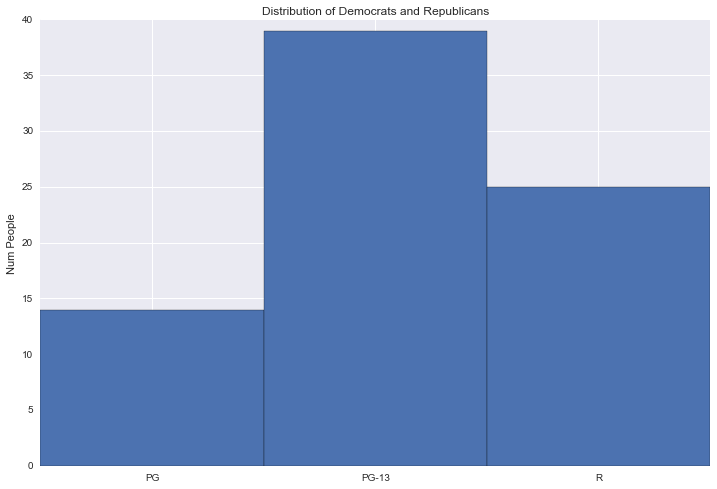

In [143]:
ind = np.array([1,2,3])
offset = .5

fig, ax = plt.subplots()
pols = ax.bar(ind, rating_counts, width=1)
fig.set_size_inches(12, 8, forward=True)

ax.set_ylabel('Num People')
ax.set_title('Distribution of Democrats and Republicans')
ax.set_xticks(ind+offset)
ax.set_xticklabels(rating_names)

In [144]:
X = movie_data[['Runtime','Budget','DomesticTotalGross']]
y = movie_data['Rating']

In [145]:
def loopKNN_cvs(X, y):
    accuracy_scores = []
    
    for i in range (1,30):
        avg_score = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=i), X, y, cv=10))
        accuracy_scores.append(avg_score)
        
    return accuracy_scores

In [146]:
KNN_cvs = loopKNN_cvs(X,y)

In [147]:
print(KNN_cvs)

[0.40238095238095239, 0.38670634920634916, 0.36746031746031743, 0.40793650793650793, 0.34900793650793649, 0.35079365079365077, 0.36686507936507934, 0.37936507936507935, 0.32896825396825397, 0.41626984126984123, 0.35119047619047616, 0.35436507936507933, 0.33373015873015871, 0.37519841269841264, 0.40019841269841266, 0.4242063492063492, 0.46071428571428569, 0.46388888888888885, 0.47817460317460314, 0.46210317460317463, 0.51527777777777772, 0.46349206349206351, 0.45158730158730159, 0.45059523809523816, 0.39285714285714285, 0.43988095238095237, 0.41488095238095235, 0.46706349206349201, 0.47023809523809518]


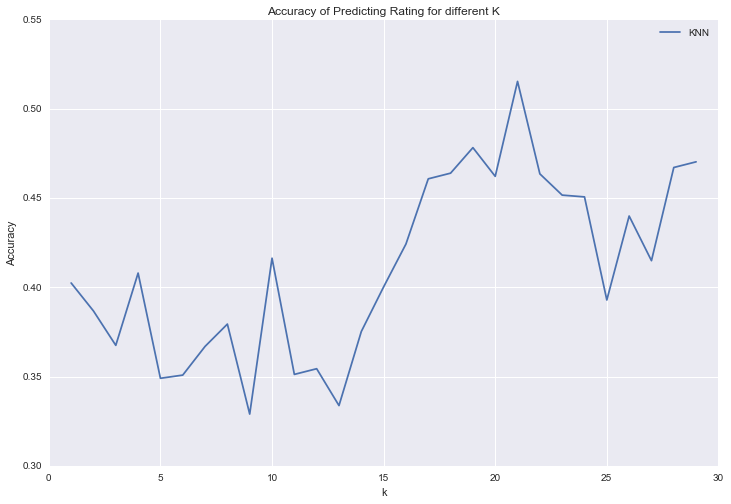

In [148]:
fig,ax = plt.subplots()

ax.plot(list(range(1,30)), KNN_cvs, label='KNN')

fig.set_size_inches(12, 8, forward=True)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of Predicting Rating for different K')
plt.legend(loc='best')

In [149]:
avg_logreg_score = np.mean(cross_val_score(LogisticRegression(), X, y, cv=10))
print(avg_logreg_score)

0.506349206349


In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

test_prediction = ['PG-13' for i in range(len(X_test))]

accuracy_score(y_test, test_prediction)

0.5

The Logistic Regression might be the best overall, however the KNN model is best at k = 21. 

In [151]:
log_reg_1 = LogisticRegression()
log_reg_1.fit(X_train,y_train)
log_reg_1.coef_

array([[ -1.15784006e-13,  -9.07544313e-09,  -1.61599310e-09],
       [ -2.98578139e-14,   2.72943760e-09,   6.44145726e-10],
       [  1.90846528e-14,  -1.20689370e-08,  -1.71531105e-09]])

Consistently 'Runtime' seems to have the least affect on the prediction.

## Challenge 12

Now you are a classification master. The representative votes dataset only had 0s and 1s. Let's just swiftly tackle the breast cancer surgery data.


In [152]:
cancer_data = read_data('haberman.csv')

In [153]:
cancer_data.head()

,Age,Year,NodesDetected,SurvivalStatus
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


### What is the average and standard deviation of the age of all of the patients?

In [154]:
age_avg = np.mean(cancer_data.Age)
age_std = np.std(cancer_data.Age)
print('Average age of all is {}\nStDev of all is {}'.format(age_avg,age_std))

Average age of all is 52.45751633986928
StDev of all is 10.78578520363183


### What is the average and standard deviation of the age of those patients that survived 5 or more years after surgery?

In [155]:
surv = cancer_data[cancer_data.SurvivalStatus == 1]
surv_age_avg = np.mean(surv.Age)
surv_age_std = np.std(surv.Age)
print('Average age of all is {}\nStDev of all is {}'.format(surv_age_avg, surv_age_std))

Average age of all is 52.01777777777778
StDev of all is 10.98765547510051


### What is the average and standard deviation of the age of those patients who survived fewer than 5 years after surgery?

In [156]:
dead = cancer_data[cancer_data.SurvivalStatus == 2]
dead_age_avg = np.mean(dead.Age)
dead_age_std = np.std(dead.Age)
print('Average age of all is {}\nStDev of all is {}'.format(dead_age_avg, dead_age_std))

Average age of all is 53.67901234567901
StDev of all is 10.10418219303131


### Plot a histogram of the ages side by side with a histogram of the number of axillary nodes.

In [157]:
nodes_index = list(cancer_data['NodesDetected'].value_counts().index)
nodes_values = list(cancer_data['NodesDetected'].value_counts().values)
age_index = list(cancer_data['Age'].value_counts().index)
age_values = list(cancer_data['Age'].value_counts().values)

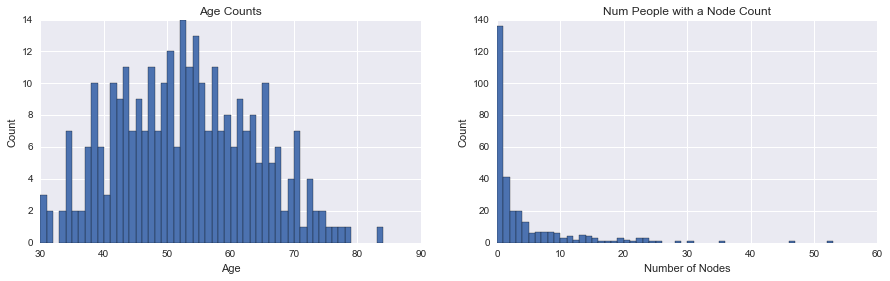

In [158]:
fig, axarr = plt.subplots(1, 2, sharex=False)
fig.set_size_inches(15, 4, forward=True)
axarr[0].bar(age_index, age_values, width=1)
axarr[1].bar(nodes_index, nodes_values, width=1)


axarr[0].set_ylabel('Count')
axarr[0].set_xlabel('Age')
axarr[0].set_title('Age Counts')
axarr[1].set_ylabel('Count')
axarr[1].set_xlabel('Number of Nodes')
axarr[1].set_title('Num People with a Node Count')




### What is the earliest year of surgery in this dataset?

In [159]:
1900 + min(cancer_data.Year)

1958

### What is the most recent year of surgery?

In [160]:
1900 + max(cancer_data.Year)

1969

### Use logistic regression to predict survival after 5 years. How well does your model do?

In [161]:
X = cancer_data[['Age', 'Year', 'NodesDetected']]
y = cancer_data.SurvivalStatus

In [162]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=4444)

In [163]:
def logRegAccCancer(X_train, X_test, y_train, y_test): 
    logreg_fit = logRegFit(X_train, y_train)
    test_prediction = logreg_fit.predict(X_test)
    
    return accuracy_score(y_test, test_prediction)

In [164]:
cancer_logreg = logRegAccCancer(X_train, X_test, y_train, y_test)
print(cancer_logreg)

0.815217391304


### What are the coefficients of logistic regression? Which features affect the outcome how?

In [165]:
logreg_fit = logRegFit(X_train, y_train)

In [166]:
logreg_fit.coef_

array([[ 0.0155515 , -0.02899279,  0.07136197]])

All three, Age, year and number of nodes, seem to affect the prediction of survival. Age and number of nodes seem to drive up the predicted value (a higher value being worse and an indicator of death) while a higher year prediction (a later surgery) seems to decrease the likelihood of death.

###  Draw the learning curve for logistic regression in this case.

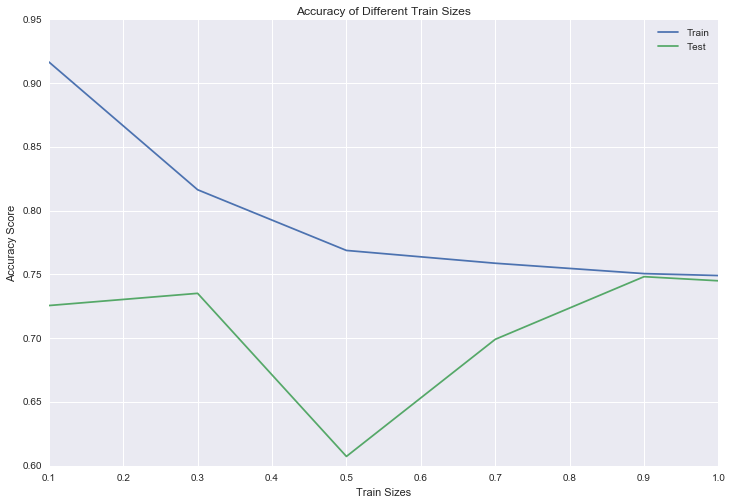

In [167]:
train_sizes = [ 0.1, 0.3, 0.5, 0.7, 0.9, 1]
train_sizes_abs, train_err, test_err = learning_curve(LogisticRegression(), X, y, train_sizes=train_sizes, cv=5)

train_cv_err = np.mean(train_err, axis=1)
test_cv_err = np.mean(test_err, axis=1)

fig,ax = plt.subplots()

ax.plot(train_sizes, train_cv_err, label='Train')
ax.plot(train_sizes, test_cv_err, label='Test')

fig.set_size_inches(12, 8, forward=True)
plt.xlabel('Train Sizes')
plt.ylabel('Accuracy Score')
plt.title('Accuracy of Different Train Sizes')
plt.legend(loc='best')